<a href="https://colab.research.google.com/github/simbrizzy/Brizzy101/blob/master/EDENCARE_Mini_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix,roc_auc_score
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import(cross_val_score,StratifiedKFold,learning_curve)


In [94]:
# Load dataset
file_path = "/content/Sample_Claims_Data.csv"
df = pd.read_csv(file_path)

In [95]:
# Display first few rows
print("Dataset Preview:\n", df.head())

Dataset Preview:
       Claim ID Member ID  Claim Amount Diagnosis Code  Procedure Code  \
0  CLAIM_00001  MEM_0001       3699.42         K35.80           81002   
1  CLAIM_00002  MEM_0002        613.79          J20.9           99213   
2  CLAIM_00003  MEM_0003       3605.77          J20.9               0   
3  CLAIM_00004  MEM_0004       3212.27          J20.9           81002   
4  CLAIM_00005  MEM_0005       4349.81          A01.0           99999   

  Provider ID Date of Service Claim Submission Date  Previous Claims  \
0    PROV_001      23/01/2023            31/01/2023                4   
1    PROV_002      16/01/2023            22/01/2023                4   
2    PROV_003      22/02/2023            24/02/2023                2   
3    PROV_004      08/03/2023            13/03/2023                0   
4    PROV_005      28/03/2023            05/04/2023                2   

   Member Age Location  Fraudulent  
0          54    Urban           1  
1          37    Urban           0  

In [96]:
# Check for missing values
print("\nMissing Values:\n", df.isnull().sum())


Missing Values:
 Claim ID                 0
Member ID                0
Claim Amount             0
Diagnosis Code           0
Procedure Code           0
Provider ID              0
Date of Service          0
Claim Submission Date    0
Previous Claims          0
Member Age               0
Location                 0
Fraudulent               0
dtype: int64


In [97]:
# Creating High Claim Amount feature (normalized)
df['High_Claim_Amount'] = df['Claim Amount'] / df.groupby('Diagnosis Code')['Claim Amount'].transform('mean')


In [98]:
# checking the data types and column information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Claim ID               1120 non-null   object 
 1   Member ID              1120 non-null   object 
 2   Claim Amount           1120 non-null   float64
 3   Diagnosis Code         1120 non-null   object 
 4   Procedure Code         1120 non-null   int64  
 5   Provider ID            1120 non-null   object 
 6   Date of Service        1120 non-null   object 
 7   Claim Submission Date  1120 non-null   object 
 8   Previous Claims        1120 non-null   int64  
 9   Member Age             1120 non-null   int64  
 10  Location               1120 non-null   object 
 11  Fraudulent             1120 non-null   int64  
 12  High_Claim_Amount      1120 non-null   float64
dtypes: float64(2), int64(4), object(7)
memory usage: 113.9+ KB


In [99]:
#changing the Date of Service and Claim Submission Date from object to DateTime data type
df['Date of Service'] = pd.to_datetime(df['Date of Service'])
df['Claim Submission Date'] = pd.to_datetime(df['Claim Submission Date'])

<ipython-input-99-a6415058e306>:2: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date of Service'] = pd.to_datetime(df['Date of Service'])
<ipython-input-99-a6415058e306>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Claim Submission Date'] = pd.to_datetime(df['Claim Submission Date'])


In [100]:
#Creating Frequent Claim Submission feature for members (last 30 days)
df['Member_Frequent_Claims_30Days'] = df.groupby('Member ID')['Claim Submission Date'].transform(lambda x: x.diff().dt.days.rolling(30).count())

In [101]:
# Assuming your DataFrame is called 'df' and has a 'Claim Submission Date' column
df['Claim_Submission_DayOfWeek'] = df['Claim Submission Date'].dt.dayofweek  # Monday=0, Sunday=6
df['Claim_Submission_Hour'] = df['Claim Submission Date'].dt.hour

In [102]:
# Converting datetime columns to numerical features
# Extract numerical features from datetime columns
df['Date_of_Service_Numeric'] = df['Date of Service'].astype(np.int64) // 10**9  # Convert to Unix timestamp
df['Claim_Submission_Date_Numeric'] = df['Claim Submission Date'].astype(np.int64) // 10**9  # Convert to Unix timestamp


In [103]:
# Dropping the original datetime columns if needed
df = df.drop(columns=['Date of Service', 'Claim Submission Date'])

In [104]:
#checking the information of the changed columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Claim ID                       1120 non-null   object 
 1   Member ID                      1120 non-null   object 
 2   Claim Amount                   1120 non-null   float64
 3   Diagnosis Code                 1120 non-null   object 
 4   Procedure Code                 1120 non-null   int64  
 5   Provider ID                    1120 non-null   object 
 6   Previous Claims                1120 non-null   int64  
 7   Member Age                     1120 non-null   int64  
 8   Location                       1120 non-null   object 
 9   Fraudulent                     1120 non-null   int64  
 10  High_Claim_Amount              1120 non-null   float64
 11  Member_Frequent_Claims_30Days  0 non-null      float64
 12  Claim_Submission_DayOfWeek     1120 non-null   i

In [105]:
# Encoding 'Diagnose Code', 'Provider ID', and 'Location', 'Member ID' columns separately
label_encoder = LabelEncoder()
df['Diagnosis Code'] = label_encoder.fit_transform(df['Diagnosis Code'])
df['Provider ID'] = label_encoder.fit_transform(df['Provider ID'])
df['Location'] = label_encoder.fit_transform(df['Location'])
df['Member ID'] = label_encoder.fit_transform(df['Member ID'])

In [106]:
#checking the information of the changed columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1120 entries, 0 to 1119
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Claim ID                       1120 non-null   object 
 1   Member ID                      1120 non-null   int64  
 2   Claim Amount                   1120 non-null   float64
 3   Diagnosis Code                 1120 non-null   int64  
 4   Procedure Code                 1120 non-null   int64  
 5   Provider ID                    1120 non-null   int64  
 6   Previous Claims                1120 non-null   int64  
 7   Member Age                     1120 non-null   int64  
 8   Location                       1120 non-null   int64  
 9   Fraudulent                     1120 non-null   int64  
 10  High_Claim_Amount              1120 non-null   float64
 11  Member_Frequent_Claims_30Days  0 non-null      float64
 12  Claim_Submission_DayOfWeek     1120 non-null   i

In [107]:
#checking the first rows of the data
df.head()

,Claim ID,Member ID,Claim Amount,Diagnosis Code,Procedure Code,Provider ID,Previous Claims,Member Age,Location,Fraudulent,High_Claim_Amount,Member_Frequent_Claims_30Days,Claim_Submission_DayOfWeek,Claim_Submission_Hour,Date_of_Service_Numeric,Claim_Submission_Date_Numeric
0,CLAIM_00001,0,3699.42,395,81002,0,4,54,29,1,1.172864,NaN,1,0,1674432000,1675123200
1,CLAIM_00002,1,613.79,344,99213,1,4,37,29,0,0.199572,NaN,6,0,1673827200,1674345600
2,CLAIM_00003,2,3605.77,344,0,2,2,43,29,1,1.172408,NaN,4,0,1677024000,1677196800
3,CLAIM_00004,3,3212.27,344,81002,3,0,34,29,0,1.044462,NaN,0,0,1678233600,1678665600
4,CLAIM_00005,4,4349.81,0,99999,4,2,36,29,0,1.038324,NaN,2,0,1679961600,1680652800


In [108]:
# Define features (X) and target variable (y)
# Assuming 'Claim Status' is the target variable
X = df.drop(columns=['Fraudulent','Claim ID'])
y = df['Fraudulent']

In [109]:
# Checking if Fraudulent is already numeric (0 and 1)
print("\nFraudulent Column Unique Values:", y.unique())


Fraudulent Column Unique Values: [1 0]


In [110]:
#Checking for Class Imbalance
print(y.value_counts(normalize=True))

Fraudulent
0    0.917857
1    0.082143
Name: proportion, dtype: float64


In [111]:
# Keep a copy of the original DataFrame columns before SMOTE
original_X_columns = df.drop(columns=['Fraudulent','Claim ID']).columns

In [112]:
#since the distribution above shows that the fraud cases are fewer that non-fraud, I apply SMOTE
# Handle class imbalance if necessary
from sklearn.impute import SimpleImputer # Import SimpleImputer

if y.value_counts().min() / y.value_counts().max() < 0.2:  # If one class is <20% of the other
    print("\nApplying SMOTE to balance the dataset...")

    # Impute missing values using the mean (you can choose other strategies)
    imputer = SimpleImputer(strategy='mean')  # Create an imputer object
    X = imputer.fit_transform(X)            # Fit and transform the data

    smote = SMOTE(random_state=42)
    X, y = smote.fit_resample(X, y)


Applying SMOTE to balance the dataset...


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Member_Frequent_Claims_30Days']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


In [113]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [114]:
# Train a simple model (Random Forest Classifier)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
rf_probs = model.predict_proba(X_test)[:, 1]

In [115]:
# Make predictions
y_pred = model.predict(X_test)
# Print the first 10 predictions
print(y_pred[:10])

[0 1 0 1 1 0 1 0 0 0]


In [116]:
# Creating a DataFrame with actual and predicted values
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(results_df.head(20))  # Print the first 20 rows

      Actual  Predicted
184        0          0
1724       1          1
251        0          0
1121       1          1
1486       1          1
111        0          0
1450       1          1
188        0          0
614        0          0
220        0          0
1175       1          1
1794       1          1
679        0          0
1368       1          1
544        0          0
746        0          0
570        0          0
1656       1          1
56         1          1
529        1          0


In [117]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2f}")


Model Accuracy: 0.95


In [118]:
# Evaluate the model performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[206   7]
 [ 15 184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       213
           1       0.96      0.92      0.94       199

    accuracy                           0.95       412
   macro avg       0.95      0.95      0.95       412
weighted avg       0.95      0.95      0.95       412



In [119]:
# Evaluate AUC-ROC score
y_prob = model.predict_proba(X_test)[:, 1]  # Get probability for the positive class
roc_auc = roc_auc_score(y_test, y_prob)
print("\nAUC-ROC Score: ", roc_auc)


AUC-ROC Score:  0.9889588789015499


In [120]:
# Training the liteGBM MODEL
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train, y_train)
lgbm_pred = lgbm_model.predict(X_test)
lgbm_probs = lgbm_model.predict_proba(X_test)[:, 1]

[LightGBM] [Info] Number of positive: 829, number of negative: 815
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3057
[LightGBM] [Info] Number of data points in the train set: 1644, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504258 -> initscore=0.017032
[LightGBM] [Info] Start training from score 0.017032


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [121]:
# Evaluate Models
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, rf_probs):.2f}")

print("\nLightGBM Performance:")
print(classification_report(y_test, lgbm_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_test, lgbm_probs):.2f}")


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       213
           1       0.96      0.92      0.94       199

    accuracy                           0.95       412
   macro avg       0.95      0.95      0.95       412
weighted avg       0.95      0.95      0.95       412

AUC-ROC Score: 0.99

LightGBM Performance:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       213
           1       0.98      0.94      0.96       199

    accuracy                           0.96       412
   macro avg       0.96      0.96      0.96       412
weighted avg       0.96      0.96      0.96       412

AUC-ROC Score: 0.98


In [129]:
# Evaluate the model performance
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[206   7]
 [ 15 184]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       213
           1       0.96      0.92      0.94       199

    accuracy                           0.95       412
   macro avg       0.95      0.95      0.95       412
weighted avg       0.95      0.95      0.95       412



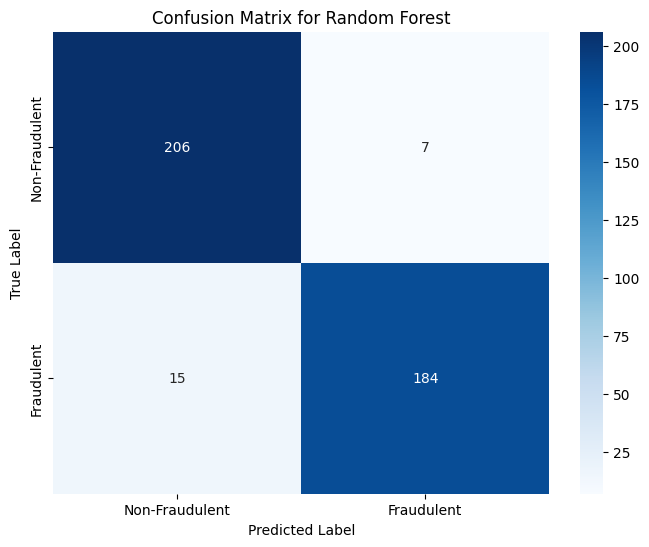

In [131]:
#Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['Non-Fraudulent', 'Fraudulent'],
            yticklabels=['Non-Fraudulent', 'Fraudulent'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Random Forest")
plt.show()

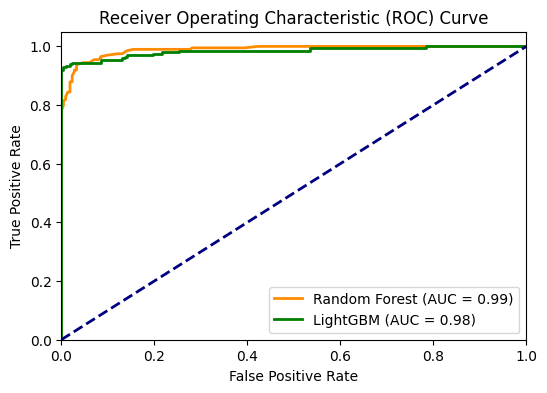

Random Forest AUC: 0.9889588789015499
LightGBM AUC: 0.9841224903862034


In [128]:
plt.figure(figsize=(6, 4))

# Plot ROC curve for Random Forest
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Random Forest (AUC = %0.2f)' % roc_auc)

# Plot ROC curve for LightGBM
plt.plot(lgbm_fpr, lgbm_tpr, color='green', lw=2, label='LightGBM (AUC = %0.2f)' % lgbm_roc_auc)

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
#Comparing the AUC Scores:
print("Random Forest AUC:", roc_auc)
print("LightGBM AUC:", lgbm_roc_auc)

Creating the risk scores for the claims and categorizing them

In [132]:

def calculate_risk_score(df):
    """
    Calculate comprehensive risk score for claims

    Parameters:
    df (DataFrame): Claims dataset

    Returns:
    DataFrame with risk score and risk category
    """
    # Claim Amount Risk (z-score normalization)
    def claim_amount_risk(amounts):
        mean = amounts.mean()
        std = amounts.std()
        return np.abs((amounts - mean) / std)

    # Previous Claims Risk
    def previous_claims_risk(claims):
        return np.log1p(claims) / np.log1p(claims.max())

    # High Claim Amount Risk
    def high_claim_risk(high_amounts):
        return np.abs(high_amounts - 1)

    # Submission Pattern Risk
    def submission_pattern_risk(days, hours):
        weekend_risk = (days >= 5).astype(int) * 0.5
        off_hours_risk = ((hours < 8) | (hours > 18)).astype(int) * 0.5
        return weekend_risk + off_hours_risk

    # Calculate risk components
    risk_components = {
        'claim_amount_risk': claim_amount_risk(df['Claim Amount']),
        'previous_claims_risk': previous_claims_risk(df['Previous Claims']),
        'high_claim_risk': high_claim_risk(df['High_Claim_Amount']),
        'submission_pattern_risk': submission_pattern_risk(
            df['Claim_Submission_DayOfWeek'],
            df['Claim_Submission_Hour']
        )
    }

    # Weighted risk score calculation
    df['Risk_Score'] = (
        0.3 * risk_components['claim_amount_risk'] +
        0.2 * risk_components['previous_claims_risk'] +
        0.3 * risk_components['high_claim_risk'] +
        0.2 * risk_components['submission_pattern_risk']
    )

    # Normalize to 0-100 scale
    df['Risk_Score'] = ((df['Risk_Score'] - df['Risk_Score'].min()) /
                        (df['Risk_Score'].max() - df['Risk_Score'].min())) * 100

    # Risk categorization
    df['Risk_Category'] = pd.cut(
        df['Risk_Score'],
        bins=[0, 30, 60, 80, 100],
        labels=['Low', 'Medium', 'High', 'Very High']
    )

    return df

# Example usage in Google Colab
# Assuming df is your preprocessed claims DataFrame
df = calculate_risk_score(df)

# Investigate high-risk claims
high_risk_claims = df[df['Risk_Category'].isin(['High', 'Very High'])]
print("High Risk Claims:")
print(high_risk_claims[['Claim ID', 'Risk_Score', 'Risk_Category']])

High Risk Claims:
       Claim ID  Risk_Score Risk_Category
16  CLAIM_00017   77.733142          High
33  CLAIM_00034   91.158549     Very High
36  CLAIM_00037   79.086874          High
80  CLAIM_00081   60.538954          High
84  CLAIM_00085   70.752878          High
93  CLAIM_00094  100.000000     Very High


In [144]:
def advanced_model_validation(model, X, y):
    """
    Comprehensive model validation techniques

    Parameters:
    model: Trained classification model
    X: Feature matrix
    y: Target variable
    """
    # 1. Cross-Validation
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='f1')
    print("Cross-Validation Scores:", cv_scores)
    print("Mean CV Score:", cv_scores.mean())


In [145]:
def create_risk_score_dataframe(df):
    """
    Calculate and create a DataFrame with risk scores

    Parameters:
    df (DataFrame): Original claims dataset

    Returns:
    DataFrame with risk score details
    """

    # Call calculate_risk_score function to get risk scores and category
    risk_df = calculate_risk_score(df)  # No need to copy here as calculate_risk_score already returns a copy

    # Reset index before combining to avoid duplicate index issues
    risk_df = risk_df.reset_index(drop=True)  # Reset index of risk_df
    df = df.reset_index(drop=True)  # Reset index of original df before concat

    # Select only risk columns and rename them to avoid conflicts
    risk_columns = risk_df[['Risk_Score', 'Risk_Category']].add_prefix('Calculated_')

    # Combine original df with risk score columns
    result_df = pd.concat([df, risk_columns], axis=1)

    return result_df

In [146]:
def continuous_model_improvement(model, new_data):
    """
    Strategies for ongoing model enhancement

    Parameters:
    model: Current trained model
    new_data: Newly available claims data
    """
    # 1. Periodic Retraining
    # Combine existing and new data
    X_updated = np.vstack([X, new_data['features']])
    y_updated = np.concatenate([y, new_data['labels']])

    # Retrain model
    updated_model = type(model)()
    updated_model.fit(X_updated, y_updated)

    # 2. Feature Importance Analysis
    feature_importances = updated_model.feature_importances_
    important_features = sorted(
        zip(original_X_columns, feature_importances),
        key=lambda x: x[1],
        reverse=True
    )

    # 3. Anomaly Detection Feedback Loop
    # Track misclassified claims for manual review
    misclassified_claims = X_test[y_test != y_pred]

    return updated_model, important_features, misclassified_claims

In [150]:
#creating the new data frame with the risk scores
def create_risk_score_dataframe(df):
    """
    Calculate and create a DataFrame with risk scores

    Parameters:
    df (DataFrame): Original claims dataset

    Returns:
    DataFrame with risk score details
    """

    # Call calculate_risk_score function to get risk scores and category
    risk_df = calculate_risk_score(df)  # No need to copy here as calculate_risk_score already returns a copy

    # Reset index before combining to avoid duplicate index issues
    risk_df = risk_df.reset_index(drop=True)  # Reset index of risk_df
    df = df.reset_index(drop=True)  # Reset index of original df before concat

    # Select only risk columns and rename them to avoid conflicts
    risk_columns = risk_df[['Risk_Score', 'Risk_Category']].add_prefix('Calculated_')

    # Combine original df with risk score columns
    result_df = pd.concat([df, risk_columns], axis=1)

    return result_df

# Usage
risk_scored_df = create_risk_score_dataframe(df)

# Print the new DataFrame with risk scores
print("DataFrame with Risk Scores:")
print(risk_scored_df[['Claim ID', 'Risk_Score', 'Risk_Category']])  # Print specific columns or the entire DataFrame

DataFrame with Risk Scores:
         Claim ID  Risk_Score Risk_Category
0     CLAIM_00001    7.153354           Low
1     CLAIM_00002   17.840559           Low
2     CLAIM_00003    6.022547           Low
3     CLAIM_00004    1.998035           Low
4     CLAIM_00005    7.791242           Low
...           ...         ...           ...
1115    CLAIM_207   11.393096           Low
1116    CLAIM_371    7.607885           Low
1117    CLAIM_961    2.373313           Low
1118    CLAIM_536    7.251588           Low
1119    CLAIM_203    4.878643           Low

[1120 rows x 3 columns]
